# Identifying Risky Loans

This algorithm uses logistic regression to identify risky loans from the german credit data set.

## Import libraries

In [2]:
## Mute warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [11]:
sns.set_style('whitegrid')

## Import data set

In [33]:
df = pd.read_csv('D:/Identifying Risky Loans/credit.csv')
df.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,...,property,age,installment_plan,housing,existing_credits,default,dependents,telephone,foreign_worker,job
0,< 0 DM,6,critical,radio/tv,1169,unknown,> 7 yrs,4,single male,none,...,real estate,67,none,own,2,1,1,yes,yes,skilled employee
1,1 - 200 DM,48,repaid,radio/tv,5951,< 100 DM,1 - 4 yrs,2,female,none,...,real estate,22,none,own,1,2,1,none,yes,skilled employee
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 yrs,2,single male,none,...,real estate,49,none,own,1,1,2,none,yes,unskilled resident
3,< 0 DM,42,repaid,furniture,7882,< 100 DM,4 - 7 yrs,2,single male,guarantor,...,building society savings,45,none,for free,1,1,2,none,yes,skilled employee
4,< 0 DM,24,delayed,car (new),4870,< 100 DM,1 - 4 yrs,3,single male,none,...,unknown/none,53,none,for free,2,2,2,none,yes,skilled employee


## EDA

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
checking_balance        1000 non-null object
months_loan_duration    1000 non-null int64
credit_history          1000 non-null object
purpose                 1000 non-null object
amount                  1000 non-null int64
savings_balance         1000 non-null object
employment_length       1000 non-null object
installment_rate        1000 non-null int64
personal_status         1000 non-null object
other_debtors           1000 non-null object
residence_history       1000 non-null int64
property                1000 non-null object
age                     1000 non-null int64
installment_plan        1000 non-null object
housing                 1000 non-null object
existing_credits        1000 non-null int64
default                 1000 non-null int64
dependents              1000 non-null int64
telephone               1000 non-null object
foreign_worker          1000 non-null object
jo

In [38]:
df.describe()

,months_loan_duration,amount,installment_rate,residence_history,age,existing_credits,default,dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,0.300000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.458487,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,0.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,0.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,0.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,1.000000,2.000000


### Default distribution

In [36]:
df['default'].value_counts()

1    700
2    300
Name: default, dtype: int64

In [37]:
##Remap 1 to be defaulters
df['default'] = df['default'].replace(to_replace=[1,2], value=[0,1])
df['default'].value_counts()

0    700
1    300
Name: default, dtype: int64

<AxesSubplot:xlabel='default', ylabel='count'>

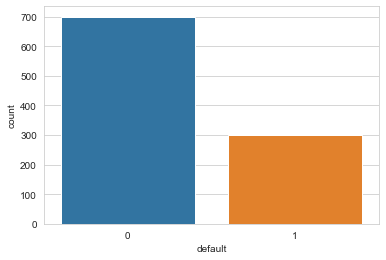

In [65]:
sns.countplot(x='default',data=df)

30% of the dataset are defaulters.

## Data cleaning

There are no missing values but we will need to convert data types.

In [39]:
df.columns

Index(['checking_balance', 'months_loan_duration', 'credit_history', 'purpose',
       'amount', 'savings_balance', 'employment_length', 'installment_rate',
       'personal_status', 'other_debtors', 'residence_history', 'property',
       'age', 'installment_plan', 'housing', 'existing_credits', 'default',
       'dependents', 'telephone', 'foreign_worker', 'job'],
      dtype='object')

In [40]:
df.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,...,property,age,installment_plan,housing,existing_credits,default,dependents,telephone,foreign_worker,job
0,< 0 DM,6,critical,radio/tv,1169,unknown,> 7 yrs,4,single male,none,...,real estate,67,none,own,2,0,1,yes,yes,skilled employee
1,1 - 200 DM,48,repaid,radio/tv,5951,< 100 DM,1 - 4 yrs,2,female,none,...,real estate,22,none,own,1,1,1,none,yes,skilled employee
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 yrs,2,single male,none,...,real estate,49,none,own,1,0,2,none,yes,unskilled resident
3,< 0 DM,42,repaid,furniture,7882,< 100 DM,4 - 7 yrs,2,single male,guarantor,...,building society savings,45,none,for free,1,0,2,none,yes,skilled employee
4,< 0 DM,24,delayed,car (new),4870,< 100 DM,1 - 4 yrs,3,single male,none,...,unknown/none,53,none,for free,2,1,2,none,yes,skilled employee


In [50]:
##Data types identity
integer_features = ['months_loan_duration','age','default','amount']
categorical_features = ['checking_balance','credit_history','purpose','savings_balance','employment_length','employment_length','installment_rate',
                       'personal_status','other_debtors','residence_history','property','installment_plan','housing','existing_credits','dependents'
                        ,'telephone','foreign_worker','job']

In [51]:
## countcolumns
len(df.columns)

21

In [56]:
## One hot encoding to change categorical variables into dummy variables
df_dummified = pd.get_dummies(data=df, columns=categorical_features,drop_first=True)

In [57]:
## Check number of new features
len(df_dummified.columns)

59

In [58]:
df_dummified.head()

,months_loan_duration,amount,age,default,checking_balance_< 0 DM,checking_balance_> 200 DM,checking_balance_unknown,credit_history_delayed,credit_history_fully repaid,credit_history_fully repaid this bank,...,housing_rent,existing_credits_2,existing_credits_3,existing_credits_4,dependents_2,telephone_yes,foreign_worker_yes,job_skilled employee,job_unemployed non-resident,job_unskilled resident
0,6,1169,67,0,1,0,0,0,0,0,...,0,1,0,0,0,1,1,1,0,0
1,48,5951,22,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,12,2096,49,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,1
3,42,7882,45,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
4,24,4870,53,1,1,0,0,1,0,0,...,0,1,0,0,1,0,1,1,0,0


In [62]:
credit_data = df_dummified

## Modeling

### Logistic regression

### Train test split

We will train our data on 70% and validate on 30% of the dataset.

In [67]:
X = credit_data.drop('default',axis=1)
y = credit_data['default']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [73]:
## instantiate logistic regression model
logmodel = LogisticRegression()

### Train model

In [74]:
## train model
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [78]:
## Predict default for test set
predictions = logmodel.predict(X_test)

### Evaluate model

In [81]:
## Evaluate model perfomance
print(confusion_matrix(y_test,predictions))

[[183  26]
 [ 51  40]]


In [82]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       209
           1       0.61      0.44      0.51        91

    accuracy                           0.74       300
   macro avg       0.69      0.66      0.67       300
weighted avg       0.73      0.74      0.73       300



In [84]:
y_test.value_counts(normalize=True)

0    0.696667
1    0.303333
Name: default, dtype: float64

## Conclusion

The logistic regression has an overall accuracy of 0.74 and from the f1 scores looks like it performs better identifying non-defaulters.

## Random Forest Classifier

We will attempt to use the more powerful random forest algorith to improve our accuracy.

In [86]:
##Instantiate randomforest model
rfc = RandomForestClassifier(n_estimators=300)

In [87]:
## Fit model
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [88]:
## Predict default for test set
predictions = rfc.predict(X_test)

### Evaluate model

In [89]:
## Evaluate model perfomance
print(confusion_matrix(y_test,predictions))

[[199  10]
 [ 64  27]]


In [90]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.76      0.95      0.84       209
           1       0.73      0.30      0.42        91

    accuracy                           0.75       300
   macro avg       0.74      0.62      0.63       300
weighted avg       0.75      0.75      0.72       300



## Conclusion

Random forest model increasesaccuracy by 1 point to 75%.

From both evaluations looks like the logistic regression has a higher recall for identifying risky loans than the random forest.